In [1]:
#Importing the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
#now we import MNIST data set
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# we are also going to scale the inputs between 1 and -1. 
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

11490434/11490434 [==============================] - 1s 0us/step


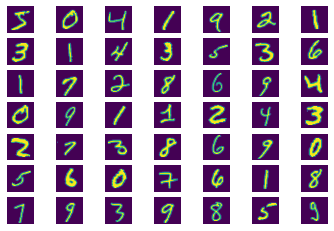

In [4]:
# we have a total of 70000 images of 28 * 28 size. let's print and see one for an clear understanding of what the data entails
for i in range(49):
    plt.subplot(7, 7, i+1)
    plt.axis("off")
    plt.imshow(x_train[i])
plt.show()

In [5]:
# we are going to flatten the data into a two dimensional dataset.
N, H, W = x_train.shape  #number, height, width
D = H * W   #dimension (28, 28)
x_train = x_train.reshape(-1, D) 
x_test = x_test.reshape(-1, D)

In [9]:
# First we start with the generator model 
latent_dim = 100
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)  #because Image pixel is between -1 to 1.
    model = Model(i, x)  #i is input x is output layer
    return model

In [8]:
# Now we build discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [11]:
# First, we will build and get the discriminator ready for classification
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
# Now we combine the both operators and compile them together
generator = build_generator(latent_dim)

In [12]:
# From the latent space we are going to sample noise for generator to acts as an input
z = Input(shape=(latent_dim,))
# And then you pass it to the generator
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

In [13]:
combined_model_gen = Model(z, fake_pred)  
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [14]:
# Now we set the parameters of the model
batch_size = 32
epochs = 12000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
#store generator and discriminator loss in each step or each epoch
d_losses = []
g_losses = []
#create a file in which generator will create and save images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [15]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)
    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5
    fig, axs = plt.subplots(rows, cols)  #fig to plot img and axis to store
    idx = 0
    for i in range(rows):  #5*5 loop means on page 25 imgs will be there
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [18]:
#FIRST we will train Discriminator(with real imgs and fake imgs)
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]  #MNIST dataset
  # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)  #generator to generate fake imgs
    fake_imgs = generator.predict(noise)
  # Train the discriminator
  # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #belong to positive class(real imgs)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #fake imgs
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  #######################
  ### Train generator ###
  #######################
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)  
  #Now we are trying to fool the discriminator that generate imgs are real that's why we are providing label as 1
  # do it again!
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model_gen.train_on_batch(noise, ones)
  # Save the losses
    d_losses.append(d_loss)  #save the loss at each epoch
    g_losses.append(g_loss)
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    if epoch % sample_period == 0:
        sample_images(epoch)

1/1 [==============================] - 1s 689ms/step
epoch: 1/12000, d_loss: 1.03, d_acc: 0.14, g_loss: 0.84
1/1 [==============================] - 0s 40ms/step
epoch: 101/12000, d_loss: 0.06, d_acc: 0.98, g_loss: 3.33
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step
epoch: 201/12000, d_loss: 0.65, d_acc: 0.62, g_loss: 1.00
1/1 [==============================] - 0s 38ms/step
epoch: 301/12000, d_loss: 0.71, d_acc: 0.42, g_loss: 0.61
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step
epoch: 401/12000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.63
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step
epoch: 501/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.65
1/1 [==============================] - 0s 37ms/step
epoch: 601/12000, d_loss: 0.69, d_acc: 0.47, g_loss: 0.68
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 37ms/step
epoch: 701/12000, d_loss: 0.68, d_acc: 0.53, g_loss: 0.70
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step
epoch: 801/12000, d_loss: 0.64, d_acc: 0.64, g_loss: 0.73
1/1 [==============================] - 0s 45ms/step
epoch: 901/12000, d_loss: 0.66, d_acc: 0.52, g_loss: 0.72
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 38ms/step
epoch: 1001/12000, d_loss: 0.66, d_acc: 0.59, g_loss: 0.74
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step
epoch: 1101/12000, d_loss: 0.65, d_acc: 0.61, g_loss: 0.77
1/1 [==============================] - 0s 42ms/step
epoch: 1201/12000, d_loss: 0.70, d_acc: 0.45, g_loss: 0.76
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step
epoch: 1301/12000, d_loss: 0.66, d_acc: 0.53, g_loss: 0.84
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step
epoch: 1401/12000, d_loss: 0.66, d_acc: 0.59, g_loss: 0.80
1/1 [==============================] - 0s 41ms/step
epoch: 1501/12000, d_loss: 0.64, d_acc: 0.56, g_loss: 0.88
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step
epoch: 1601/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 40ms/step
epoch: 1701/12000, d_loss: 0.63, d_acc: 0.62, g_loss: 0.80


1/1 [==============================] - 0s 43ms/step
epoch: 1801/12000, d_loss: 0.66, d_acc: 0.52, g_loss: 0.85
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step
epoch: 1901/12000, d_loss: 0.64, d_acc: 0.67, g_loss: 0.79
1/1 [==============================] - 0s 42ms/step
epoch: 2001/12000, d_loss: 0.74, d_acc: 0.47, g_loss: 0.78
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 38ms/step
epoch: 2101/12000, d_loss: 0.60, d_acc: 0.69, g_loss: 0.82
1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step
epoch: 2201/12000, d_loss: 0.71, d_acc: 0.56, g_loss: 0.80
1/1 [==============================] - 0s 43ms/step
epoch: 2301/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.83
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 42ms/step
epoch: 2401/12000, d_loss: 0.66, d_acc: 0.66, g_loss: 0.77
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 2501/12000, d_loss: 0.66, d_acc: 0.69, g_loss: 0.83
1/1 [==============================] - 0s 48ms/step
epoch: 2601/12000, d_loss: 0.66, d_acc: 0.58, g_loss: 0.78
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 42ms/step
epoch: 2701/12000, d_loss: 0.67, d_acc: 0.53, g_loss: 0.80
1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 48ms/step
epoch: 2801/12000, d_loss: 0.63, d_acc: 0.69, g_loss: 0.76
1/1 [==============================] - 0s 48ms/step
epoch: 2901/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 59ms/step
epoch: 3001/12000, d_loss: 0.65, d_acc: 0.62, g_loss: 0.78
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 3101/12000, d_loss: 0.74, d_acc: 0.42, g_loss: 0.78
1/1 [==============================] - 0s 55ms/step
epoch: 3201/12000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.78
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 49ms/step
epoch: 3301/12000, d_loss: 0.69, d_acc: 0.47, g_loss: 0.84
1/1 [==============================] - 0s 54ms/step
epoch: 3401/12000, d_loss: 0.65, d_acc: 0.69, g_loss: 0.79
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 53ms/step
epoch: 3501/12000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 54ms/step
epoch: 3601/12000, d_loss: 0.68, d_acc: 0.55, g_loss: 0.79
1/1 [==============================] - 0s 55ms/step
epoch: 3701/12000, d_loss: 0.68, d_acc: 0.53, g_loss: 0.79
1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 38ms/step
epoch: 3801/12000, d_loss: 0.73, d_acc: 0.47, g_loss: 0.83
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 44ms/step
epoch: 3901/12000, d_loss: 0.66, d_acc: 0.58, g_loss: 0.82
1/1 [==============================] - 0s 58ms/step
epoch: 4001/12000, d_loss: 0.67, d_acc: 0.62, g_loss: 0.81
1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 33ms/step
epoch: 4101/12000, d_loss: 0.67, d_acc: 0.55, g_loss: 0.85
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 47ms/step
epoch: 4201/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.80
1/1 [==============================] - 0s 43ms/step
epoch: 4301/12000, d_loss: 0.66, d_acc: 0.69, g_loss: 0.80
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 79ms/step
epoch: 4401/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.80
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 52ms/step
epoch: 4501/12000, d_loss: 0.70, d_acc: 0.55, g_loss: 0.74
1/1 [==============================] - 0s 50ms/step
epoch: 4601/12000, d_loss: 0.70, d_acc: 0.52, g_loss: 0.74
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 4701/12000, d_loss: 0.68, d_acc: 0.61, g_loss: 0.78
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 58ms/step
epoch: 4801/12000, d_loss: 0.66, d_acc: 0.62, g_loss: 0.76
1/1 [==============================] - 0s 64ms/step
epoch: 4901/12000, d_loss: 0.69, d_acc: 0.58, g_loss: 0.77
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 5001/12000, d_loss: 0.68, d_acc: 0.58, g_loss: 0.77
1/1 [==============================] - 0s 46ms/step
epoch: 5101/12000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.85
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 50ms/step
epoch: 5201/12000, d_loss: 0.68, d_acc: 0.52, g_loss: 0.79
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 48ms/step
epoch: 5301/12000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.79
1/1 [==============================] - 0s 63ms/step
epoch: 5401/12000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.84
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 47ms/step
epoch: 5501/12000, d_loss: 0.72, d_acc: 0.52, g_loss: 0.82
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 68ms/step
epoch: 5601/12000, d_loss: 0.68, d_acc: 0.50, g_loss: 0.84
1/1 [==============================] - 0s 68ms/step
epoch: 5701/12000, d_loss: 0.76, d_acc: 0.36, g_loss: 0.78
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 53ms/step
epoch: 5801/12000, d_loss: 0.71, d_acc: 0.52, g_loss: 0.83
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 72ms/step
epoch: 5901/12000, d_loss: 0.70, d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 76ms/step
epoch: 6001/12000, d_loss: 0.69, d_acc: 0.47, g_loss: 0.85
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 49ms/step
epoch: 6101/12000, d_loss: 0.73, d_acc: 0.50, g_loss: 0.83
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 69ms/step
epoch: 6201/12000, d_loss: 0.67, d_acc: 0.55, g_loss: 0.78
1/1 [==============================] - 0s 71ms/step
epoch: 6301/12000, d_loss: 0.74, d_acc: 0.44, g_loss: 0.78
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 63ms/step
epoch: 6401/12000, d_loss: 0.70, d_acc: 0.58, g_loss: 0.81
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 54ms/step
epoch: 6501/12000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.81
1/1 [==============================] - 0s 86ms/step
epoch: 6601/12000, d_loss: 0.69, d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 88ms/step
epoch: 6701/12000, d_loss: 0.70, d_acc: 0.52, g_loss: 0.72
1/1 [==============================] - 0s 87ms/step
epoch: 6801/12000, d_loss: 0.67, d_acc: 0.61, g_loss: 0.74
1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 74ms/step
epoch: 6901/12000, d_loss: 0.66, d_acc: 0.59, g_loss: 0.78
1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 87ms/step
epoch: 7001/12000, d_loss: 0.65, d_acc: 0.64, g_loss: 0.81
1/1 [==============================] - 0s 83ms/step
epoch: 7101/12000, d_loss: 0.67, d_acc: 0.55, g_loss: 0.77
1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 72ms/step
epoch: 7201/12000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.76
1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 96ms/step
epoch: 7301/12000, d_loss: 0.68, d_acc: 0.56, g_loss: 0.85
1/1 [==============================] - 0s 78ms/step
epoch: 7401/12000, d_loss: 0.65, d_acc: 0.56, g_loss: 0.84
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 94ms/step
epoch: 7501/12000, d_loss: 0.68, d_acc: 0.55, g_loss: 0.72
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 85ms/step
epoch: 7601/12000, d_loss: 0.72, d_acc: 0.48, g_loss: 0.83
1/1 [==============================] - 0s 120ms/step
epoch: 7701/12000, d_loss: 0.68, d_acc: 0.62, g_loss: 0.81
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 65ms/step
epoch: 7801/12000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.73
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 93ms/step
epoch: 7901/12000, d_loss: 0.66, d_acc: 0.53, g_loss: 0.77
1/1 [==============================] - 0s 84ms/step
epoch: 8001/12000, d_loss: 0.69, d_acc: 0.56, g_loss: 0.73
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 94ms/step
epoch: 8101/12000, d_loss: 0.70, d_acc: 0.59, g_loss: 0.76
1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 91ms/step
epoch: 8201/12000, d_loss: 0.63, d_acc: 0.66, g_loss: 0.80
1/1 [==============================] - 0s 95ms/step
epoch: 8301/12000, d_loss: 0.68, d_acc: 0.55, g_loss: 0.78
1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 97ms/step
epoch: 8401/12000, d_loss: 0.69, d_acc: 0.52, g_loss: 0.82
1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 110ms/step
epoch: 8501/12000, d_loss: 0.69, d_acc: 0.56, g_loss: 0.76
1/1 [==============================] - 0s 122ms/step
epoch: 8601/12000, d_loss: 0.66, d_acc: 0.64, g_loss: 0.80
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 108ms/step
epoch: 8701/12000, d_loss: 0.65, d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 111ms/step
epoch: 8801/12000, d_loss: 0.68, d_acc: 0.61, g_loss: 0.79
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 106ms/step
epoch: 8901/12000, d_loss: 0.69, d_acc: 0.58, g_loss: 0.83
1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 121ms/step
epoch: 9001/12000, d_loss: 0.68, d_acc: 0.58, g_loss: 0.76
1/1 [==============================] - 0s 101ms/step
epoch: 9101/12000, d_loss: 0.68, d_acc: 0.55, g_loss: 0.74
1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 100ms/step
epoch: 9201/12000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.80
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 109ms/step
epoch: 9301/12000, d_loss: 0.70, d_acc: 0.55, g_loss: 0.78
1/1 [==============================] - 0s 112ms/step
epoch: 9401/12000, d_loss: 0.68, d_acc: 0.53, g_loss: 0.78
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 108ms/step
epoch: 9501/12000, d_loss: 0.73, d_acc: 0.44, g_loss: 0.79
1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 108ms/step
epoch: 9601/12000, d_loss: 0.63, d_acc: 0.64, g_loss: 0.86
1/1 [==============================] - 0s 127ms/step
epoch: 9701/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.80
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 108ms/step
epoch: 9801/12000, d_loss: 0.67, d_acc: 0.64, g_loss: 0.78
1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 100ms/step
epoch: 9901/12000, d_loss: 0.72, d_acc: 0.48, g_loss: 0.84
1/1 [==============================] - 0s 111ms/step
epoch: 10001/12000, d_loss: 0.72, d_acc: 0.53, g_loss: 0.78
1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 76ms/step
epoch: 10101/12000, d_loss: 0.71, d_acc: 0.50, g_loss: 0.81
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 146ms/step
epoch: 10201/12000, d_loss: 0.67, d_acc: 0.64, g_loss: 0.82
1/1 [==============================] - 0s 134ms/step
epoch: 10301/12000, d_loss: 0.63, d_acc: 0.62, g_loss: 0.87
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 145ms/step
epoch: 10401/12000, d_loss: 0.63, d_acc: 0.66, g_loss: 0.78
1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 145ms/step
epoch: 10501/12000, d_loss: 0.70, d_acc: 0.53, g_loss: 0.82
1/1 [==============================] - 0s 151ms/step
epoch: 10601/12000, d_loss: 0.67, d_acc: 0.62, g_loss: 0.78
1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 130ms/step
epoch: 10701/12000, d_loss: 0.67, d_acc: 0.56, g_loss: 0.76
1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 129ms/step
epoch: 10801/12000, d_loss: 0.65, d_acc: 0.66, g_loss: 0.84
1/1 [==============================] - 0s 118ms/step
epoch: 10901/12000, d_loss: 0.70, d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 156ms/step
epoch: 11001/12000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.75
1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 187ms/step
epoch: 11101/12000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.77
1/1 [==============================] - 0s 196ms/step
epoch: 11201/12000, d_loss: 0.67, d_acc: 0.61, g_loss: 0.80
1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 149ms/step
epoch: 11301/12000, d_loss: 0.72, d_acc: 0.47, g_loss: 0.80
1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 179ms/step
epoch: 11401/12000, d_loss: 0.67, d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 178ms/step
epoch: 11501/12000, d_loss: 0.69, d_acc: 0.59, g_loss: 0.76
1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 158ms/step
epoch: 11601/12000, d_loss: 0.68, d_acc: 0.52, g_loss: 0.81
1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 169ms/step
epoch: 11701/12000, d_loss: 0.69, d_acc: 0.53, g_loss: 0.80
1/1 [==============================] - 0s 160ms/step
epoch: 11801/12000, d_loss: 0.73, d_acc: 0.47, g_loss: 0.80
1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 167ms/step
epoch: 11901/12000, d_loss: 0.72, d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 182ms/step


1/1 [==============================] - 0s 182ms/step


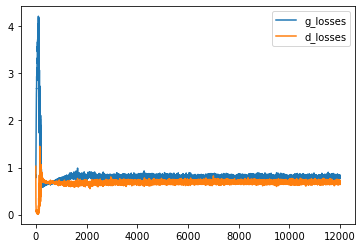

In [19]:
# we plot the loss values of both discriminator and generator
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

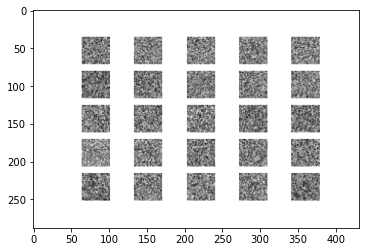

In [20]:
# to see the results
# the below are the images that were generated at the first epoch.
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

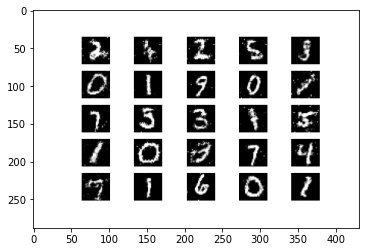

In [21]:
# to see the results
# the below are the images that were generated at the first epoch.
from skimage.io import imread
a = imread('gan_images/10000.png')
plt.imshow(a)

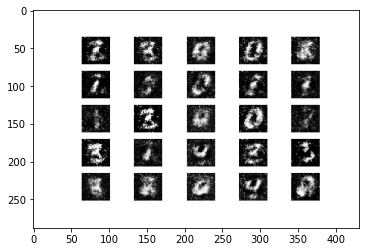

In [24]:
# to see the results
# the below are the images that were generated at the first epoch.
from skimage.io import imread
a = imread('gan_images/1000.png')
plt.imshow(a)